# **DA 231o Data Engineering at Scale August 2023**
# **Project : Project : Amazon Product Reviews :: Sentiment Analysis**

### Authors:

*   Chandramouli Sanchi(schandramoul@iisc.ac.in)
*   Josyula Sai Tejaswi(tejaswisai@iisc.ac.in)
*   Mupparthi Vikram(vikramm@iisc.ac.in)



## Resources - https://www.kaggle.com/datasets/bittlingmayer/amazonreviews


### ***Spark Setup***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls -al /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive
-r-------- 1 root root 220400553 Sep  4 09:38 /content/drive/Shareddrives/DA231-2023/assignments/spark-3.0.3-bin-hadoop2.7.tgz


### ***Spark Context Creation***

In [ ]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

### ***Common Imports***

In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import expr, lower, regexp_replace, split, explode
from pyspark.sql.functions import udf, regexp_extract, col, length, count, concat_ws
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

### ***Step 1:Load Data***

In [ ]:
train_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/train.ft.txt.bz2")
test_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/test.ft.txt.bz2")

In [ ]:
train_df.show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                           

In [ ]:
# Count the number of rows in the Train DataFrame
num_rows = train_df.count()

# Count the number of columns in the DataFrame
num_columns = len(train_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 3600000
Number of columns: 1


In [ ]:
# Count the number of rows in the Test DataFrame
num_rows = test_df.count()

# Count the number of columns in the DataFrame
num_columns = len(test_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 400000
Number of columns: 1


# **Exploratory Data Analysis**

In [ ]:
# data has a single column named "value", rename to "text"
train_df = train_df.withColumnRenamed("value", "text")
test_df = test_df.withColumnRenamed("value", "text")

# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
train_df = tokenizer.transform(train_df)
test_df = tokenizer.transform(test_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
train_df = remover.transform(train_df)
test_df = remover.transform(test_df)

+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           3600000|
|   mean| 442.6463147222222|
| stddev|237.55257109885113|
|    min|                83|
|    max|              1026|
+-------+------------------+



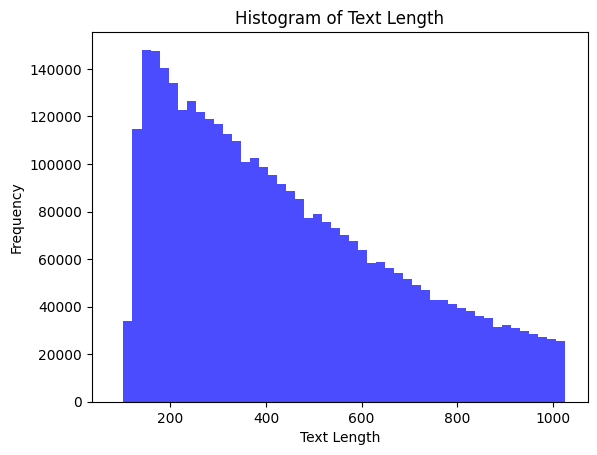

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Add a column for the length of the text
train_df = train_df.withColumn("text_length", length(train_df["text"]))
test_df = test_df.withColumn("text_length", length(test_df["text"]))

# Show basic statistics about text length
train_df.select("text_length").describe().show()

# Plot a histogram of text length
text_lengths = train_df.select("text_length").rdd.flatMap(lambda x: x).collect()
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Show the first few rows of the preprocessed DataFrame
train_df.select("text", "filtered_words").show(truncate=False)

In [ ]:
# Assuming the labels are in the format __label__1 and __label__2
train_df = train_df.withColumn("label", train_df["text"].substr(10, 1).cast("int"))
test_df = test_df.withColumn("label", test_df["text"].substr(10, 1).cast("int"))

# Count the occurrences of each label
label_counts = train_df.groupBy("label").agg(count("*").alias("count"))

# Show the counts
label_counts.show()

# Alternatively, we can collect the counts as a dictionary for easier access
label_counts_dict = label_counts.rdd.collectAsMap()
print("Number of positive labels (__label__2):", label_counts_dict.get(2, 0))
print("Number of negative labels (__label__1):", label_counts_dict.get(1, 0))

+-----+-------+
|label|  count|
+-----+-------+
|    1|1800000|
|    2|1800000|
+-----+-------+

Number of positive labels (__label__2): 1800000
Number of negative labels (__label__1): 1800000


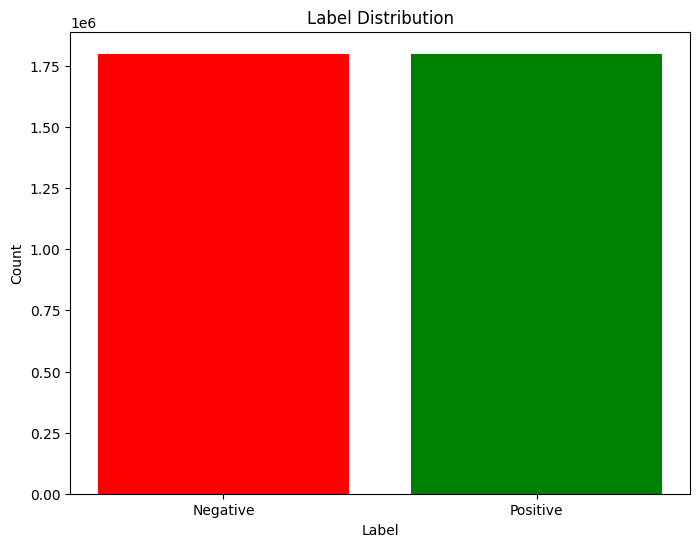

In [ ]:
# Count the occurrences of each label
label_counts = train_df.groupBy("label").agg(count("*").alias("count"))

# Convert to Pandas DataFrame for visualization
label_counts_pd = label_counts.toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts_pd["label"], label_counts_pd["count"], color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks([1, 2], ['Negative', 'Positive'])
plt.show()

## Perfect balanced dataset

In [ ]:
memoryissue = 0

In [ ]:
if memoryissue:
  positive_reviews = train_df.filter(train_df["label"] == 2).select("filtered_words")
  negative_reviews = train_df.filter(train_df["label"] == 1).select("filtered_words")

  # Convert the Spark DataFrame columns to lists of words
  positive_words_list = positive_reviews.rdd.flatMap(lambda x: x[0]).collect()
  negative_words_list = negative_reviews.rdd.flatMap(lambda x: x[0]).collect()

  # Convert lists to strings
  positive_words_text = ' '.join(positive_words_list)
  negative_words_text = ' '.join(negative_words_list)

  # Create WordCloud for Positive Reviews
  positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words_text)
  plt.figure(figsize=(10, 5))
  plt.imshow(positive_wordcloud, interpolation='bilinear')
  plt.title('Word Cloud - Positive Reviews')
  plt.axis('off')
  plt.show()

  # Create WordCloud for Negative Reviews
  negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words_text)
  plt.figure(figsize=(10, 5))
  plt.imshow(negative_wordcloud, interpolation='bilinear')
  plt.title('Word Cloud - Negative Reviews')
  plt.axis('off')
  plt.show()


Py4JJavaError: ignored

## Reduce the samples to avoid out of memeory issues

In [ ]:
# Reload dataset
train_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/train.ft.txt.bz2")
test_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/test.ft.txt.bz2")

In [ ]:
# Set the seed for reproducibility
seed = 42

# Randomly sample 5% rows from the train DataFrame
train_df = train_df.sample(False, 0.05, seed)  # Change the fraction to get the desired sample size

# Randomly sample 1% rows from the test DataFrame
test_df = test_df.sample(False, 0.05, seed)  # Change the fraction to get the desired sample size

# Check the updated sizes
num_rows_train = train_df.count()
num_rows_test = test_df.count()

print("Updated train data frame size:")
print("Number of rows:", num_rows_train)
print("Number of columns:", num_columns)

print("\nUpdated test data frame size:")
print("Number of rows:", num_rows_test)
print("Number of columns:", num_columns)

Updated train data frame size:
Number of rows: 179897
Number of columns: 1

Updated test data frame size:
Number of rows: 19964
Number of columns: 1


In [ ]:
# data has a single column named "value", rename to "text"
train_df = train_df.withColumnRenamed("value", "text")
test_df = test_df.withColumnRenamed("value", "text")

In [ ]:
# Assuming the labels are in the format __label__1 and __label__2
train_df = train_df.withColumn("label", train_df["text"].substr(10, 1).cast("int"))
test_df = test_df.withColumn("label", test_df["text"].substr(10, 1).cast("int"))

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
train_df = tokenizer.transform(train_df)
test_df = tokenizer.transform(test_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
train_df = remover.transform(train_df)
test_df = remover.transform(test_df)

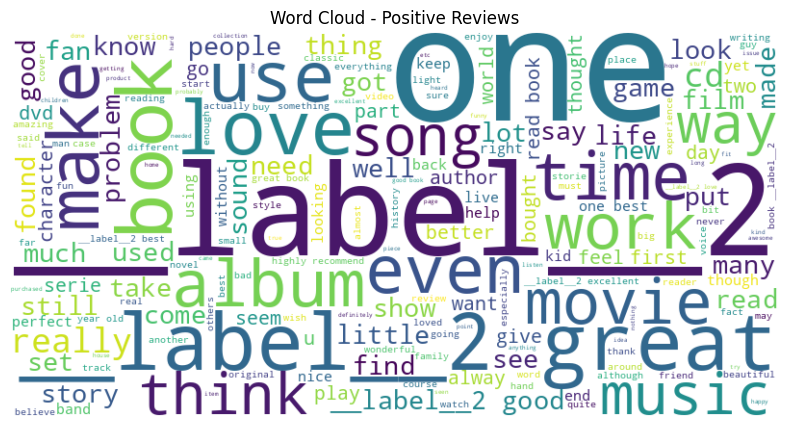

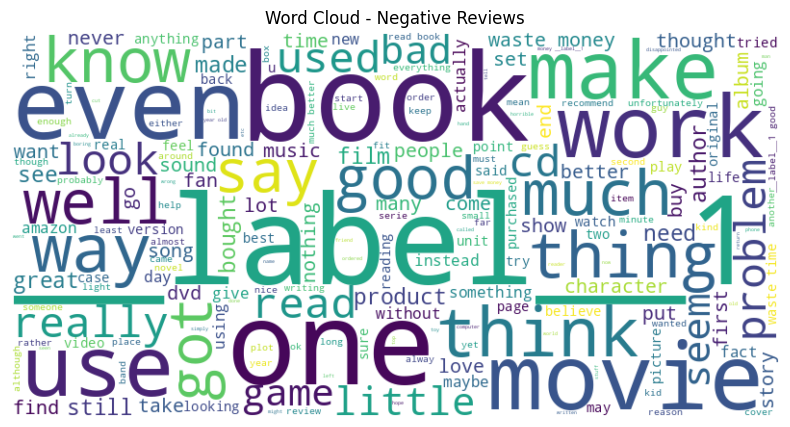

In [ ]:
positive_reviews = train_df.filter(train_df["label"] == 2).select("filtered_words")
negative_reviews = train_df.filter(train_df["label"] == 1).select("filtered_words")

# Convert the Spark DataFrame columns to lists of words
positive_words_list = positive_reviews.rdd.flatMap(lambda x: x[0]).collect()
negative_words_list = negative_reviews.rdd.flatMap(lambda x: x[0]).collect()

# Convert lists to strings
positive_words_text = ' '.join(positive_words_list)
negative_words_text = ' '.join(negative_words_list)

# Create WordCloud for Positive Reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words_text)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')
plt.show()

# Create WordCloud for Negative Reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words_text)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')
plt.show()

### ***NOTE: Word embedding taking too much time due to size, hence limiting***

In [ ]:
# Reload dataset
train_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/train.ft.txt.bz2")
test_df = spark.read.text("/content/drive/MyDrive/Amazon_Products_Dataset/test.ft.txt.bz2")

In [ ]:
# Set the seed for reproducibility
seed = 42

# Randomly sample 5% rows from the train DataFrame
train_df = train_df.sample(False, 0.05, seed)  # Change the fraction to get the desired sample size

# Randomly sample 1% rows from the test DataFrame
test_df = test_df.sample(False, 0.05, seed)  # Change the fraction to get the desired sample size

# Check the updated sizes
num_rows_train = train_df.count()
num_rows_test = test_df.count()

print("Updated train data frame size:")
print("Number of rows:", num_rows_train)
print("Number of columns:", num_columns)

print("\nUpdated test data frame size:")
print("Number of rows:", num_rows_test)
print("Number of columns:", num_columns)

Updated train data frame size:
Number of rows: 179897
Number of columns: 1

Updated test data frame size:
Number of rows: 19964
Number of columns: 1


In [ ]:
train_df = train_df.withColumnRenamed("value", "raw_text")
test_df = test_df.withColumnRenamed("value", "raw_text")

In [ ]:
train_df.show(1, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|raw_text                                                                                                                                                                                                                                                                                                  

In [ ]:
test_df.show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|raw_text                                                                                                                                                                                                                                                                                                                                                                               


```
Data Format = <_label_sentiment_number> <text>

*  <sentiment>: Represents the sentiment label, where "__label__2" is a positive sentiment and "__label__1" is a negative sentiment.

*   <text>: Contains the actual text of the review.
```



In [ ]:
# For the training data
# Extract the sentiment label and convert to an integer
train_df = train_df.withColumn("label", regexp_extract("raw_text", r"__label__(\d)", 1).cast("int"))

# Extract the review text (excluding the label)
train_df = train_df.withColumn("text", expr("substring(raw_text, 12)"))

# For the testing data
# Extract the sentiment label and convert to an integer
test_df = test_df.withColumn("label", regexp_extract("raw_text", r"__label__(\d)", 1).cast("int"))

# Extract the review text (excluding the label)
test_df = test_df.withColumn("text", expr("substring(raw_text, 12)"))

In [ ]:
train_df.show()

+--------------------+-----+--------------------+
|            raw_text|label|                text|
+--------------------+-----+--------------------+
|__label__2 A roma...|    2|A romantic zen ba...|
|__label__2 Creepy...|    2|Creepy: Wow, what...|
|__label__1 No ins...|    1|No instructions i...|
|__label__1 Too Un...|    1|Too Uncomfortable...|
|__label__2 You ne...|    2|You need a good m...|
|__label__2 no goo...|    2|no good: I gave i...|
|__label__1 no tec...|    1|no technical info...|
|__label__2 Loved ...|    2|Loved it! (P.S. S...|
|__label__1 Will n...|    1|Will not be purch...|
|__label__2 MYSTIC...|    2|MYSTICAL THINKMAN...|
|__label__2 Amazin...|    2|Amazing!: LJ smit...|
|__label__1 More t...|    1|More than Thomas,...|
|__label__1 Distur...|    1|Disturbing: Altho...|
|__label__2 Fun To...|    2|Fun To Listen To....|
|__label__2 Wonder...|    2|Wonderful. A thor...|
|__label__2 Though...|    2|Thoughtful, conte...|
|__label__2 God's ...|    2|God's Zoo: Wonder...|


In [ ]:
test_df.show()

+--------------------+-----+--------------------+
|            raw_text|label|                text|
+--------------------+-----+--------------------+
|__label__2 Simple...|    2|Simple, Durable, ...|
|__label__1 1, and...|    1|1, and thats bein...|
|__label__1 Painfu...|    1|Painful: This boo...|
|__label__1 one of...|    1|one of the worst ...|
|__label__1 Not th...|    1|Not the worst, bu...|
|__label__2 There ...|    2|There is no way a...|
|__label__2 The Be...|    2|The Best Present ...|
|__label__1 Biogra...|    1|Biography of Wrig...|
|__label__2 Long H...|    2|Long Hot Summer: ...|
|__label__2 Dense ...|    2|Dense with knowle...|
|__label__2 Deserv...|    2|Deserving of the ...|
|__label__2 Impres...|    2|Impressive: One o...|
|__label__2 Franke...|    2|Frankenstein Cont...|
|__label__2 Great ...|    2|Great classic: I ...|
|__label__1 Lackin...|    1|Lacking: The movi...|
|__label__2 Amazin...|    2|Amazingly soft ha...|
|__label__2 TRANFO...|    2|TRANFORMERS DARK ...|


In [ ]:
# Drop the "raw_text" column from train_df
train_df = train_df.drop("raw_text")

# Drop the "raw_text" column from test_df
test_df = test_df.drop("raw_text")

In [ ]:
# Select and show only the "text" column
train_df.show(5, truncate=True)

test_df.show(5, truncate=True)

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    2|A romantic zen ba...|
|    2|Creepy: Wow, what...|
|    1|No instructions i...|
|    1|Too Uncomfortable...|
|    2|You need a good m...|
+-----+--------------------+
only showing top 5 rows

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    2|Simple, Durable, ...|
|    1|1, and thats bein...|
|    1|Painful: This boo...|
|    1|one of the worst ...|
|    1|Not the worst, bu...|
+-----+--------------------+
only showing top 5 rows



### ***Step 2: PreProcess the Data***


*   Lower case
*   Remove special characters, numbers and spaces
*   Tokenize
*   Remove stop words
*   Lemmatize







In [ ]:
# Download the stopwords resource using NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Convert text to lowercase
train_df = train_df.withColumn("text", lower(train_df["text"]))
test_df = test_df.withColumn("text", lower(test_df["text"]))

# Remove special characters, numbers, and extra spaces
train_df = train_df.withColumn("text", regexp_replace(train_df["text"], "[^a-zA-Z\\s]", ""))
train_df = train_df.withColumn("text", regexp_replace(train_df["text"], "\\s+", " "))

test_df = test_df.withColumn("text", regexp_replace(test_df["text"], "[^a-zA-Z\\s]", ""))
test_df = test_df.withColumn("text", regexp_replace(test_df["text"], "\\s+", " "))

In [ ]:
# Tokenize the text (split into words)
train_df = train_df.withColumn("words", split(train_df["text"], " "))
test_df = test_df.withColumn("words", split(test_df["text"], " "))

In [ ]:
# Select and show only the "words" column
print("Train DataFrame - 'words' column:")
train_df.select("words").show(5, truncate=False)

print("Test DataFrame - 'words' column:")
test_df.select("words").show(5, truncate=False)

Train DataFrame - 'words' column:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                             

In [ ]:
# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
train_df = stopwords_remover.transform(train_df).drop("words")
test_df = stopwords_remover.transform(test_df).drop("words")

In [ ]:
# Select and show only the "filtered_words" column
print("Train DataFrame - 'filtered_words' column:")
train_df.select("filtered_words").show(5, truncate=False)

print("Test DataFrame - 'filtered_words' column:")
test_df.select("filtered_words").show(5, truncate=False)

Train DataFrame - 'filtered_words' column:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# Lemmatize the words
lemmatizer = WordNetLemmatizer()
lemmatize_udf = udf(lambda words: [lemmatizer.lemmatize(word) for word in words], ArrayType(StringType()))

train_df = train_df.withColumn("lemmatized_words", lemmatize_udf(train_df["filtered_words"]))
test_df = test_df.withColumn("lemmatized_words", lemmatize_udf(test_df["filtered_words"]))

In [ ]:
# Select and show only the "lemmatized_words" column
print("Train DataFrame - 'lemmatized_words' column:")
train_df.select("lemmatized_words").show(5, truncate=False)

print("Test DataFrame - 'lemmatized_words' column:")
test_df.select("lemmatized_words").show(5, truncate=False)

Train DataFrame - 'lemmatized_words' column:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|lemmatized_words                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
test_df.columns

['label', 'text', 'filtered_words', 'lemmatized_words']

In [ ]:
#Limit will pick first N samples
# Limit the train DataFrame to 100,000 rows
#train_df = train_df.limit(100000)

# Limit the test DataFrame to 10,000 rows
#test_df = test_df.limit(10000)

# Check the updated sizes
#num_rows_train = train_df.count()
#num_rows_test = test_df.count()

#print("Updated train data frame size:")
#print("Number of rows:", num_rows_train)
#print("Number of columns:", num_columns)

#print("\nUpdated test data frame size:")
#print("Number of rows:", num_rows_test)
#print("Number of columns:", num_columns)

In [ ]:
tfidf = 1

In [ ]:
if tfidf:
  # TF
  hashingTF = HashingTF(inputCol="lemmatized_words", outputCol="rawFeatures", numFeatures=5000)
  train_df = hashingTF.transform(train_df)
  test_df = hashingTF.transform(test_df)

  # IDF
  idf = IDF(inputCol="rawFeatures", outputCol="features")
  idf_model = idf.fit(train_df)
  train_df = idf_model.transform(train_df)
  test_df = idf_model.transform(test_df)

  # Drop intermediate columns
  train_df = train_df.drop("filtered_words", "lemmatized_words", "rawFeatures")
  test_df = test_df.drop("filtered_words", "lemmatized_words", "rawFeatures")
else :
  # Convert words to numerical features using CountVectorizer
  cv = CountVectorizer(inputCol="lemmatized_words", outputCol="features", vocabSize=10000)
  cv_model = cv.fit(train_df)
  train_df = cv_model.transform(train_df).drop("filtered_words", "lemmatized_words")
  test_df = cv_model.transform(test_df).drop("filtered_words", "lemmatized_words")

In [ ]:

# Show the DataFrames
train_df.select("features").show(5, truncate=False)
test_df.select("features").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
train_df.columns

['label', 'text', 'features']

### ***Step 3: Fit Model***


*   Logistic Regresion
*   Simple Vector Machine(SVM)
*   Decision Classifier





In [ ]:
# Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=30, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

# Make predictions on the test set
lr_predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy,weightedPrecision,f1")

# Compute multiple metrics
accuracy = evaluator.setMetricName("accuracy").evaluate(lr_predictions)
weighted_precision = evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)
weighted_f1 = evaluator.setMetricName("f1").evaluate(lr_predictions)

# Print the metrics
print("Evaluation Metrics With Logistic Regression")
print("Accuracy:", accuracy)
print("Weighted Precision:", weighted_precision)
print("Weighted F1 Score:", weighted_f1)

Evaluation Metrics With Logistic Regression
Accuracy: 0.49353836906431575
Weighted Precision: 0.24358012173866475
Weighted F1 Score: 0.3261785927753096


In [ ]:
lr_predictions.show()

Confusion Matrix - Logistic Regression:
DenseMatrix([[ 9853.,     0.],
             [10111.,     0.]])


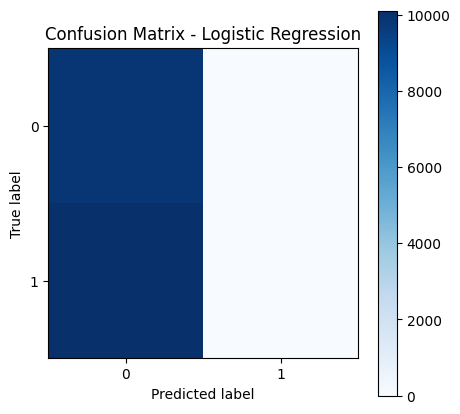

In [ ]:
# Cast the "label" column to DoubleType
lr_predictions = lr_predictions.withColumn("label", col("label").cast(DoubleType()))

# Convert DataFrame to RDD for using MulticlassMetrics
lr_predictionAndLabels = lr_predictions.select("prediction", "label").rdd

# Instantiate metrics objects
lr_metrics = MulticlassMetrics(lr_predictionAndLabels)

# Print confusion matrix
print("Confusion Matrix - Logistic Regression:")
print(lr_metrics.confusionMatrix())

# Plot confusion matrix
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    classes = [0, 1]  # Labels for binary classification
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(lr_metrics.confusionMatrix().toArray(), "Confusion Matrix - Logistic Regression")

**True Positives (TP)**: 9853
These are the correctly predicted positive instances, in this case, the model correctly predicted the positive class.

**False Positives (FP)**: 0
The model incorrectly predicted these as positive when they were actually negative.

**True Negatives (TN)**: 0
These are the correctly predicted negative instances, in this case, the model correctly predicted the negative class.

**False Negatives (FN)**: 10111
The model incorrectly predicted these as negative when they were actually positive.

In summary, it appears that the model is performing well in predicting the true positives (9853) but is misclassifying a significant number of actual positives as negatives (10111 false negatives). The model is not predicting any false positives (FP) or true negatives (TN) in this scenario.

** Issue seems to be with less datapoints. If we increase the number of data points it may perform better

In [ ]:
train_df.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    2|
+-----+



In [ ]:
# Count the number of entries for each unique label in the training data
train_label_counts = train_df.groupBy("label").count().orderBy("label")
print("Number of entries for each unique label in training data:")
train_label_counts.show()

# Count the number of entries for each unique label in the test data
test_label_counts = test_df.groupBy("label").count().orderBy("label")
print("Number of entries for each unique label in test data:")
test_label_counts.show()

Number of entries for each unique label in training data:
+-----+------+
|label| count|
+-----+------+
|    1|179788|
|    2|179975|
+-----+------+

Number of entries for each unique label in test data:
+-----+-----+
|label|count|
+-----+-----+
|    1|19815|
|    2|20065|
+-----+-----+



**Data is perfectly balanced, Logistic Regression is not doing good for this dataset**

In [ ]:
# Train a Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_df)

# Make predictions on the test set
predictions_dt = dt_model.transform(test_df)

# Evaluate the Decision Tree model
evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy,weightedPrecision,f1")

# Compute multiple metrics
accuracy_dt = evaluator_dt.setMetricName("accuracy").evaluate(predictions_dt)
weighted_precision_dt = evaluator_dt.setMetricName("weightedPrecision").evaluate(predictions_dt)
weighted_f1_dt = evaluator_dt.setMetricName("f1").evaluate(predictions_dt)

# Print the metrics
print("Evaluation Metrics With Decision Tree")
print("Accuracy:", accuracy_dt)
print("Weighted Precision:", weighted_precision_dt)
print("Weighted F1 Score:", weighted_f1_dt)

Evaluation Metrics With Decision Tree
Accuracy: 0.6914493480441324
Weighted Precision: 0.7114171138772412
Weighted F1 Score: 0.6844969561499293


In [ ]:
predictions_dt.show()

Confusion Matrix - Decision Tree:
DenseMatrix([[16687.,  3128.],
             [ 9177., 10888.]])


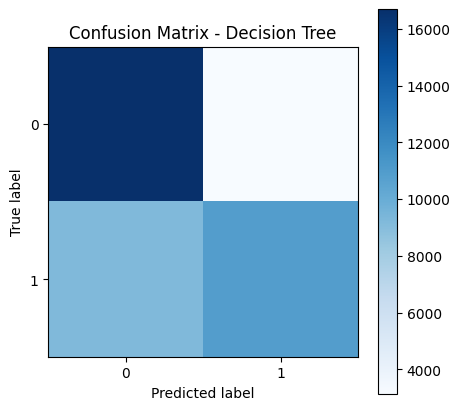

In [ ]:
# Cast the "label" column to DoubleType
predictions_dt = predictions_dt.withColumn("label", col("label").cast(DoubleType()))

# Convert DataFrame to RDD for using MulticlassMetrics
dt_predictionAndLabels = predictions_dt.select("prediction", "label").rdd

# Instantiate metrics objects
dt_metrics = MulticlassMetrics(dt_predictionAndLabels)

# Print confusion matrix
print("Confusion Matrix - Decision Tree:")
print(dt_metrics.confusionMatrix())

# Plot confusion matrix
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    classes = [0, 1]  # Labels for binary classification
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrix for Decision Tree
plot_confusion_matrix(dt_metrics.confusionMatrix().toArray(), "Confusion Matrix - Decision Tree")

**True Positives (TP): 5469**
These are the correctly predicted positive instances, in this case, the model correctly predicted the positive class.

**False Positives (FP): 1547**
The model incorrectly predicted these as positive when they were actually negative.

**True Negatives (TN): 8403**
These are the correctly predicted negative instances, in this case, the model correctly predicted the negative class.

**False Negatives (FN): 4471**
The model incorrectly predicted these as negative when they were actually positive.

In summary, the decision tree model is performing relatively well in predicting both true positives and true negatives. However, there are a significant number of false positives (FP) and false negatives (FN), indicating some misclassifications.

**ERROR** :: /content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/utils.py in raise_from(e)

IllegalArgumentException: requirement failed: LinearSVC only supports binary classification. 3 classes detected in LinearSVC_dc2ac47b50ea__labelCol

Check why this error

In [ ]:
# Train a SVM model
#svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
#svm_model = svm.fit(train_df)

# Make predictions on the test set
#predictions_svm = svm_model.transform(test_df)

# Evaluate the SVM model
#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Print Accuracy
#accuracy_svm = evaluator.evaluate(predictions_svm)
#print("SVM Accuracy:", accuracy_svm)

In [ ]:
# Initialize the Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction", smoothing=1.0, modelType="multinomial")

#Train Naive Bayes model
nb_model = nb.fit(train_df)

# Make predictions on the test set
predictions_nb = nb_model.transform(test_df)

# Evaluate the NaiveBayes model
evaluator_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Print Accuracy
accuracy_nb = evaluator_nb.evaluate(predictions_nb)
print("NaiveBayes Accuracy:", accuracy_nb)

NaiveBayes Accuracy: 0.07517552657973922
